In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Load and prepare dataset
def load_and_preprocess_data(file_path):
    from scipy.io import arff
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)

    # Encode the target column
    label_encoder = LabelEncoder()
    df['Class'] = label_encoder.fit_transform(df['Class'])

    # Split features and target
    X = df.drop(columns=['Class'])
    y = df['Class']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return df, X_train, X_test, y_train, y_test

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   float64
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   float64
 6   Extent             3810 non-null   float64
 7   Class              3810 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 238.2 KB
None

Summary Statistics:
               Area    Perimeter  Major_Axis_Length  Minor_Axis_Length  \
count   3810.000000  3810.000000        3810.000000        3810.000000   
mean   12667.727559   454.239180         188.776222          86.313750   
std     1732.367706    35.597081          17.448679           5.729817   
min     7551.000000   359.

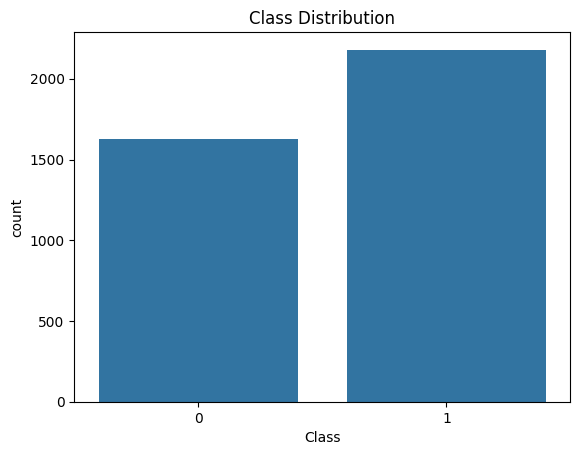

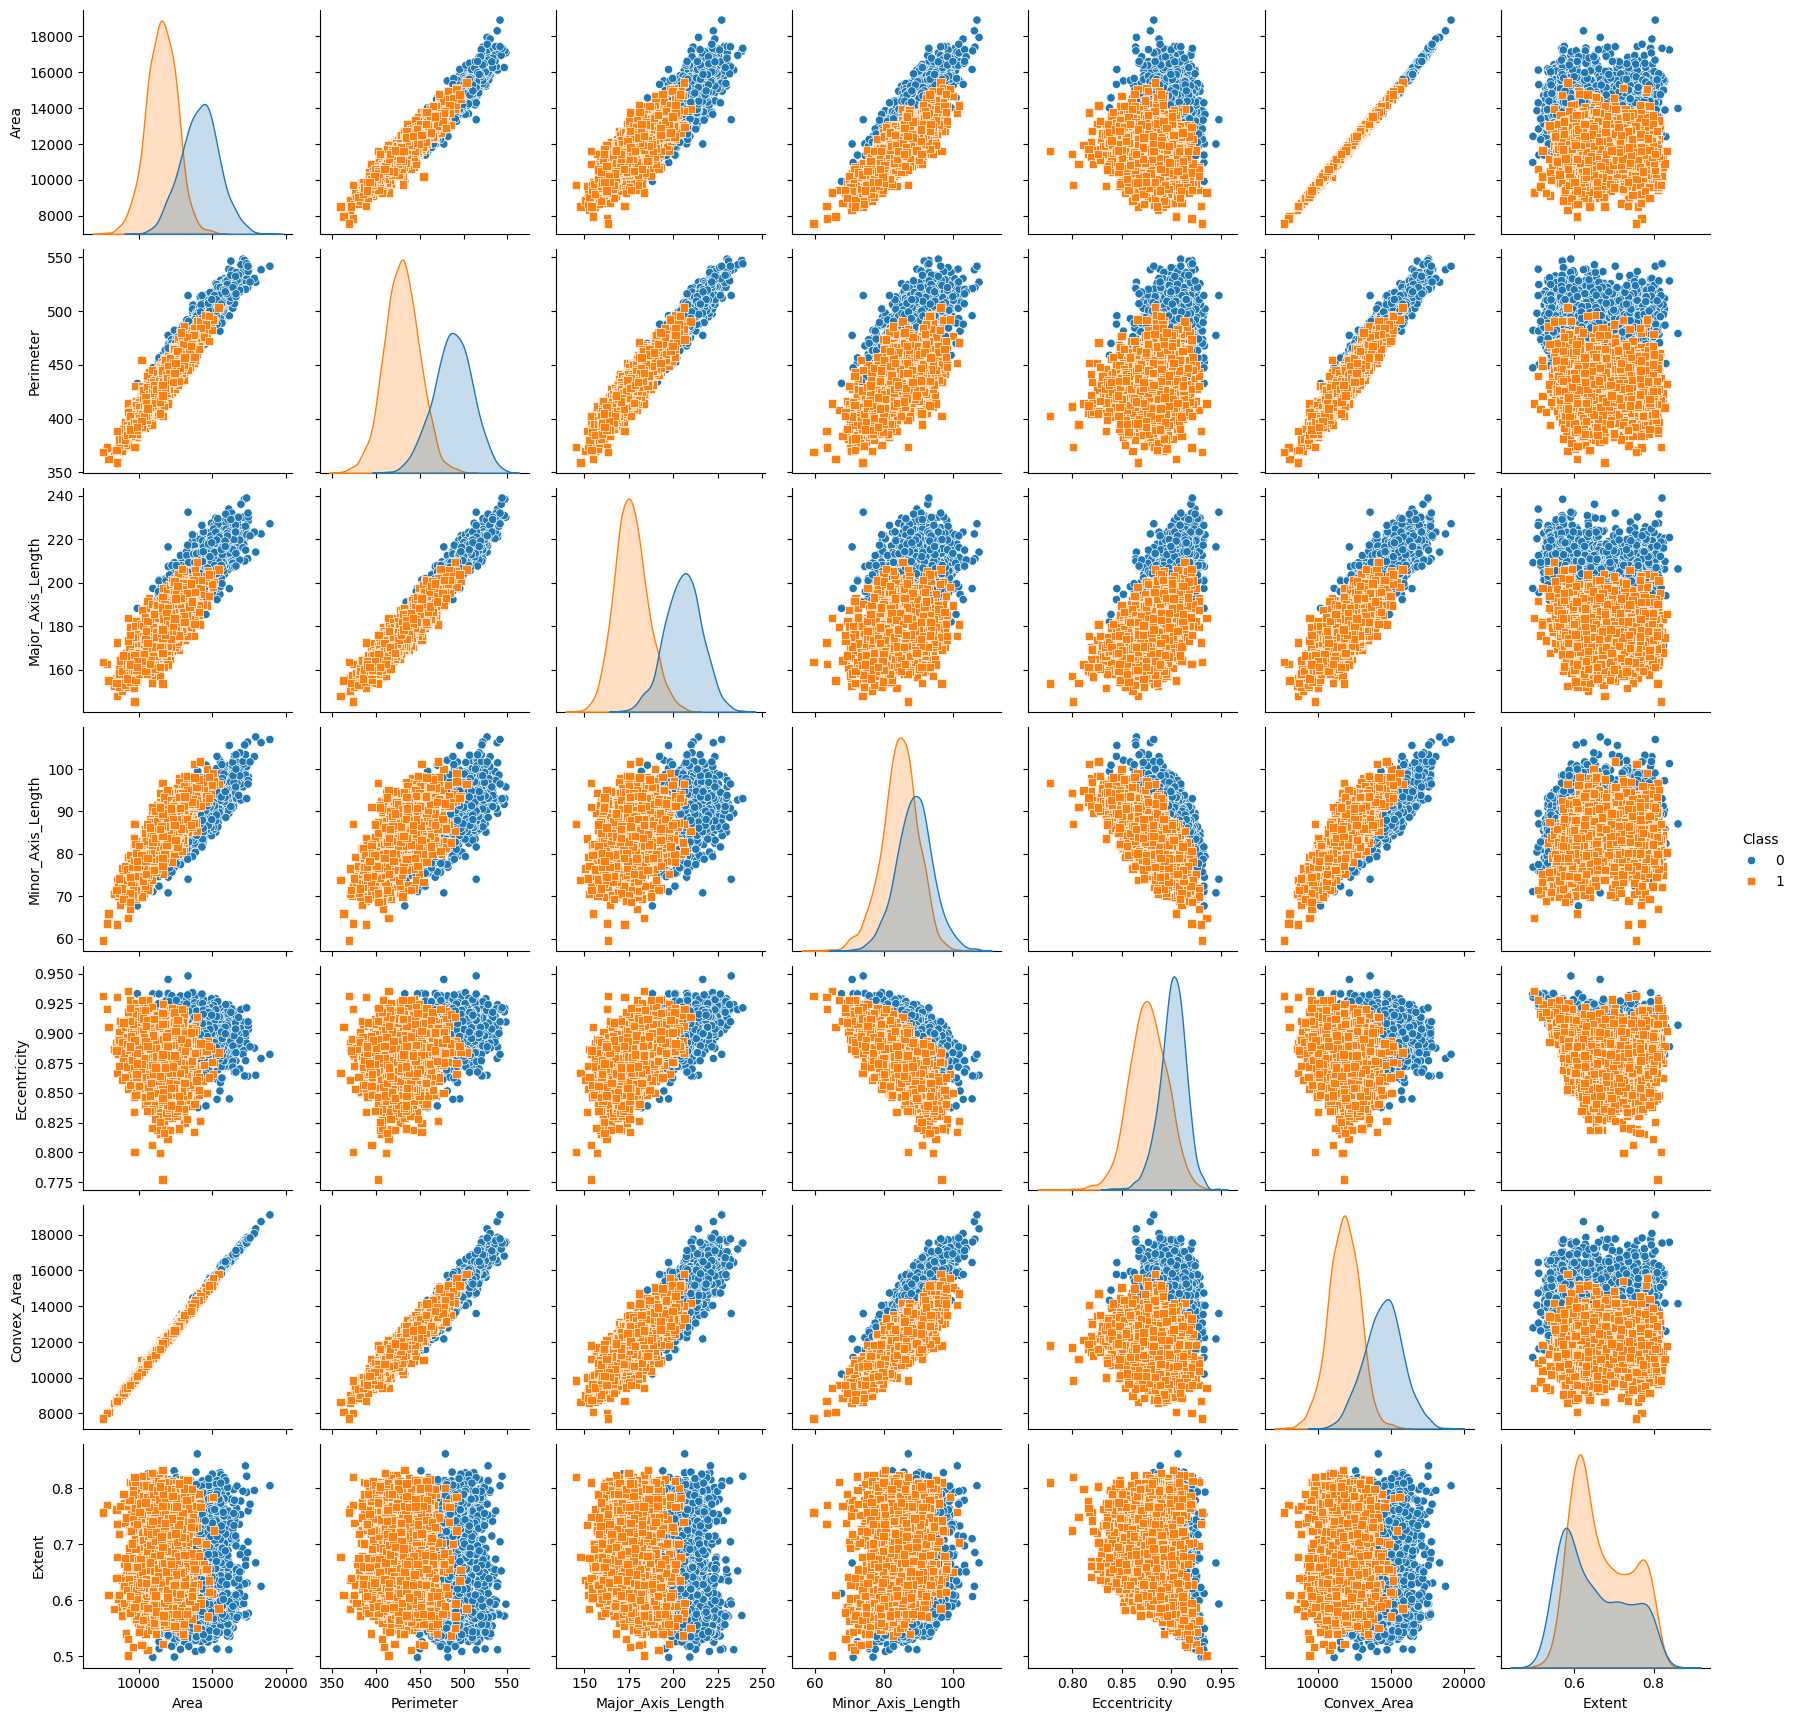

In [18]:
# File path to the dataset
file_path = '/Rice_Cammeo_Osmancik.arff'
df, X_train, X_test, y_train, y_test = load_and_preprocess_data(file_path)

# Exploratory Data Analysis (EDA)
def perform_eda(data):
    print("Dataset Info:")
    print(data.info())
    print("\nSummary Statistics:")
    print(data.describe())

    # Check class distribution
    sns.countplot(x='Class', data=data)
    plt.title("Class Distribution")
    plt.show()

    # Pairplot for feature visualization
    sns.pairplot(data, hue='Class', diag_kind='kde', markers=["o", "s"])
    plt.show()

perform_eda(df)

In [19]:
# Data Preparation (Normalization)
def normalize_data(X_train, X_test):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = normalize_data(X_train, X_test)

In [20]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [21]:
# Create DataLoader for batch processing
def create_data_loader(X, y, batch_size):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [22]:
# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_fn):
        super(MLPModel, self).__init__()
        layers = []
        in_features = input_size

        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(activation_fn)
            in_features = hidden_units

        layers.append(nn.Linear(in_features, 2))  # Output layer (binary classification)
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [23]:
# Train and evaluate the model
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Evaluate
    model.eval()
    with torch.no_grad():
        y_pred = []
        y_true = []
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(y_batch.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Final Accuracy: {accuracy:.4f}")
    return accuracy

In [24]:
# Configuration variables
input_size = X_train.shape[1]
hidden_layer_configs = [[4], [8], [16], [32], [64]]  # Example configurations
activation_functions = {'Linear': nn.Identity(), 'Sigmoid': nn.Sigmoid(), 'ReLU': nn.ReLU(), 'Softmax': nn.Softmax(dim=1), 'Tanh': nn.Tanh()}
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64, 128, 256, 512]
epochs_list = [1, 10, 25, 50, 100, 250]

In [25]:
# Experiment: Hidden Layer Comparison
results_hidden_layers = []
for hidden_layers in hidden_layer_configs:
    train_loader = create_data_loader(X_train_tensor, y_train_tensor, batch_size=32)
    test_loader = create_data_loader(X_test_tensor, y_test_tensor, batch_size=32)

    model = MLPModel(input_size, hidden_layers, nn.ReLU())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    accuracy = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=50)

    results_hidden_layers.append({
        'hidden_layers': hidden_layers,
        'accuracy': accuracy
    })

Epoch [1/50], Loss: 0.7259
Epoch [2/50], Loss: 0.6916
Epoch [3/50], Loss: 0.6787
Epoch [4/50], Loss: 0.6705
Epoch [5/50], Loss: 0.6617
Epoch [6/50], Loss: 0.6515
Epoch [7/50], Loss: 0.6373
Epoch [8/50], Loss: 0.6228
Epoch [9/50], Loss: 0.6056
Epoch [10/50], Loss: 0.5855
Epoch [11/50], Loss: 0.5615
Epoch [12/50], Loss: 0.5357
Epoch [13/50], Loss: 0.5085
Epoch [14/50], Loss: 0.4799
Epoch [15/50], Loss: 0.4508
Epoch [16/50], Loss: 0.4233
Epoch [17/50], Loss: 0.3977
Epoch [18/50], Loss: 0.3744
Epoch [19/50], Loss: 0.3528
Epoch [20/50], Loss: 0.3340
Epoch [21/50], Loss: 0.3184
Epoch [22/50], Loss: 0.3059
Epoch [23/50], Loss: 0.2920
Epoch [24/50], Loss: 0.2803
Epoch [25/50], Loss: 0.2713
Epoch [26/50], Loss: 0.2625
Epoch [27/50], Loss: 0.2549
Epoch [28/50], Loss: 0.2481
Epoch [29/50], Loss: 0.2421
Epoch [30/50], Loss: 0.2370
Epoch [31/50], Loss: 0.2354
Epoch [32/50], Loss: 0.2293
Epoch [33/50], Loss: 0.2261
Epoch [34/50], Loss: 0.2219
Epoch [35/50], Loss: 0.2177
Epoch [36/50], Loss: 0.2145
E

In [26]:
# Experiment: Activation Function Comparison
results_activation = []
for activation_name, activation_fn in activation_functions.items():
    train_loader = create_data_loader(X_train_tensor, y_train_tensor, batch_size=32)
    test_loader = create_data_loader(X_test_tensor, y_test_tensor, batch_size=32)

    model = MLPModel(input_size, [16], activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    accuracy = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=50)

    results_activation.append({
        'activation': activation_name,
        'accuracy': accuracy
    })

Epoch [1/50], Loss: 0.7321
Epoch [2/50], Loss: 0.6962
Epoch [3/50], Loss: 0.6650
Epoch [4/50], Loss: 0.6339
Epoch [5/50], Loss: 0.6021
Epoch [6/50], Loss: 0.5689
Epoch [7/50], Loss: 0.5354
Epoch [8/50], Loss: 0.5015
Epoch [9/50], Loss: 0.4681
Epoch [10/50], Loss: 0.4364
Epoch [11/50], Loss: 0.4073
Epoch [12/50], Loss: 0.3810
Epoch [13/50], Loss: 0.3585
Epoch [14/50], Loss: 0.3382
Epoch [15/50], Loss: 0.3210
Epoch [16/50], Loss: 0.3056
Epoch [17/50], Loss: 0.2919
Epoch [18/50], Loss: 0.2818
Epoch [19/50], Loss: 0.2707
Epoch [20/50], Loss: 0.2638
Epoch [21/50], Loss: 0.2550
Epoch [22/50], Loss: 0.2482
Epoch [23/50], Loss: 0.2428
Epoch [24/50], Loss: 0.2397
Epoch [25/50], Loss: 0.2334
Epoch [26/50], Loss: 0.2280
Epoch [27/50], Loss: 0.2255
Epoch [28/50], Loss: 0.2215
Epoch [29/50], Loss: 0.2193
Epoch [30/50], Loss: 0.2166
Epoch [31/50], Loss: 0.2132
Epoch [32/50], Loss: 0.2105
Epoch [33/50], Loss: 0.2092
Epoch [34/50], Loss: 0.2061
Epoch [35/50], Loss: 0.2060
Epoch [36/50], Loss: 0.2046
E

In [27]:
# Experiment: Learning Rate Comparison
results_learning_rate = []
for lr in learning_rates:
    train_loader = create_data_loader(X_train_tensor, y_train_tensor, batch_size=32)
    test_loader = create_data_loader(X_test_tensor, y_test_tensor, batch_size=32)

    model = MLPModel(input_size, [16], nn.ReLU())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    accuracy = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=50)

    results_learning_rate.append({
        'learning_rate': lr,
        'accuracy': accuracy
    })

Epoch [1/50], Loss: 1.9756
Epoch [2/50], Loss: 2.0239
Epoch [3/50], Loss: 2.0713
Epoch [4/50], Loss: 1.9006
Epoch [5/50], Loss: 1.9673
Epoch [6/50], Loss: 2.0114
Epoch [7/50], Loss: 2.0179
Epoch [8/50], Loss: 2.1591
Epoch [9/50], Loss: 2.0337
Epoch [10/50], Loss: 2.0001
Epoch [11/50], Loss: 2.1686
Epoch [12/50], Loss: 2.2135
Epoch [13/50], Loss: 2.3008
Epoch [14/50], Loss: 2.3013
Epoch [15/50], Loss: 1.8883
Epoch [16/50], Loss: 1.9795
Epoch [17/50], Loss: 2.1151
Epoch [18/50], Loss: 2.1793
Epoch [19/50], Loss: 1.9994
Epoch [20/50], Loss: 2.1235
Epoch [21/50], Loss: 2.1823
Epoch [22/50], Loss: 2.2057
Epoch [23/50], Loss: 2.0068
Epoch [24/50], Loss: 2.0424
Epoch [25/50], Loss: 2.1754
Epoch [26/50], Loss: 1.9714
Epoch [27/50], Loss: 1.9955
Epoch [28/50], Loss: 2.1656
Epoch [29/50], Loss: 2.1781
Epoch [30/50], Loss: 1.9650
Epoch [31/50], Loss: 1.9626
Epoch [32/50], Loss: 1.8933
Epoch [33/50], Loss: 2.1375
Epoch [34/50], Loss: 2.0147
Epoch [35/50], Loss: 1.9746
Epoch [36/50], Loss: 2.1891
E

In [28]:
# Experiment: Batch Size Comparison
results_batch_size = []
for batch_size in batch_sizes:
    train_loader = create_data_loader(X_train_tensor, y_train_tensor, batch_size=batch_size)
    test_loader = create_data_loader(X_test_tensor, y_test_tensor, batch_size=batch_size)

    model = MLPModel(input_size, [16], nn.ReLU())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    accuracy = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=50)

    results_batch_size.append({
        'batch_size': batch_size,
        'accuracy': accuracy
    })

Epoch [1/50], Loss: 0.6946
Epoch [2/50], Loss: 0.6592
Epoch [3/50], Loss: 0.6309
Epoch [4/50], Loss: 0.5971
Epoch [5/50], Loss: 0.5543
Epoch [6/50], Loss: 0.5052
Epoch [7/50], Loss: 0.4542
Epoch [8/50], Loss: 0.4052
Epoch [9/50], Loss: 0.3643
Epoch [10/50], Loss: 0.3300
Epoch [11/50], Loss: 0.3031
Epoch [12/50], Loss: 0.2824
Epoch [13/50], Loss: 0.2664
Epoch [14/50], Loss: 0.2523
Epoch [15/50], Loss: 0.2423
Epoch [16/50], Loss: 0.2338
Epoch [17/50], Loss: 0.2266
Epoch [18/50], Loss: 0.2204
Epoch [19/50], Loss: 0.2156
Epoch [20/50], Loss: 0.2107
Epoch [21/50], Loss: 0.2078
Epoch [22/50], Loss: 0.2040
Epoch [23/50], Loss: 0.2014
Epoch [24/50], Loss: 0.1999
Epoch [25/50], Loss: 0.1966
Epoch [26/50], Loss: 0.1958
Epoch [27/50], Loss: 0.1936
Epoch [28/50], Loss: 0.1922
Epoch [29/50], Loss: 0.1907
Epoch [30/50], Loss: 0.1892
Epoch [31/50], Loss: 0.1888
Epoch [32/50], Loss: 0.1872
Epoch [33/50], Loss: 0.1861
Epoch [34/50], Loss: 0.1862
Epoch [35/50], Loss: 0.1854
Epoch [36/50], Loss: 0.1851
E

In [29]:
# Experiment: Epoch Comparison
results_epochs = []
for epochs in epochs_list:
    train_loader = create_data_loader(X_train_tensor, y_train_tensor, batch_size=32)
    test_loader = create_data_loader(X_test_tensor, y_test_tensor, batch_size=32)

    model = MLPModel(input_size, [16], nn.ReLU())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    accuracy = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=epochs)

    results_epochs.append({
        'epochs': epochs,
        'accuracy': accuracy
    })

Epoch [1/1], Loss: 0.6990
Final Accuracy: 0.5801
Epoch [1/10], Loss: 0.6753
Epoch [2/10], Loss: 0.6604
Epoch [3/10], Loss: 0.6451
Epoch [4/10], Loss: 0.6283
Epoch [5/10], Loss: 0.6091
Epoch [6/10], Loss: 0.5873
Epoch [7/10], Loss: 0.5628
Epoch [8/10], Loss: 0.5348
Epoch [9/10], Loss: 0.5062
Epoch [10/10], Loss: 0.4756
Final Accuracy: 0.9029
Epoch [1/25], Loss: 0.6951
Epoch [2/25], Loss: 0.6810
Epoch [3/25], Loss: 0.6685
Epoch [4/25], Loss: 0.6550
Epoch [5/25], Loss: 0.6402
Epoch [6/25], Loss: 0.6232
Epoch [7/25], Loss: 0.6033
Epoch [8/25], Loss: 0.5815
Epoch [9/25], Loss: 0.5576
Epoch [10/25], Loss: 0.5318
Epoch [11/25], Loss: 0.5046
Epoch [12/25], Loss: 0.4769
Epoch [13/25], Loss: 0.4501
Epoch [14/25], Loss: 0.4235
Epoch [15/25], Loss: 0.3998
Epoch [16/25], Loss: 0.3771
Epoch [17/25], Loss: 0.3583
Epoch [18/25], Loss: 0.3405
Epoch [19/25], Loss: 0.3254
Epoch [20/25], Loss: 0.3100
Epoch [21/25], Loss: 0.2975
Epoch [22/25], Loss: 0.2868
Epoch [23/25], Loss: 0.2783
Epoch [24/25], Loss: 0

In [30]:
# Display results for each comparison
print("Results: Hidden Layer Comparison")
print(pd.DataFrame(results_hidden_layers))

print("\nResults: Activation Function Comparison")
print(pd.DataFrame(results_activation))

print("\nResults: Learning Rate Comparison")
print(pd.DataFrame(results_learning_rate))

print("\nResults: Batch Size Comparison")
print(pd.DataFrame(results_batch_size))

print("\nResults: Epoch Comparison")
print(pd.DataFrame(results_epochs))

Results: Hidden Layer Comparison
  hidden_layers  accuracy
0           [4]  0.908136
1           [8]  0.898950
2          [16]  0.904199
3          [32]  0.912073
4          [64]  0.902887

Results: Activation Function Comparison
  activation  accuracy
0     Linear  0.905512
1    Sigmoid  0.896325
2       ReLU  0.904199
3    Softmax  0.572178
4       Tanh  0.908136

Results: Learning Rate Comparison
   learning_rate  accuracy
0        10.0000  0.572178
1         1.0000  0.901575
2         0.1000  0.916010
3         0.0100  0.908136
4         0.0010  0.649606
5         0.0001  0.572178

Results: Batch Size Comparison
   batch_size  accuracy
0          16  0.910761
1          32  0.905512
2          64  0.897638
3         128  0.888451
4         256  0.884514
5         512  0.666667

Results: Epoch Comparison
   epochs  accuracy
0       1  0.580052
1      10  0.902887
2      25  0.893701
3      50  0.904199
4     100  0.913386
5     250  0.916010
